In [ ]:
# PCA Analysis: Hidden State Structure Across Layers

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from utils.grid_utils import *
from utils.model_utils import *

MODEL_PATH = "/cs/student/projects1/aibh/2024/cbaumgar/model_chunked/checkpoint-73125"
model, tokenizer = load_model_and_tokenizer(MODEL_PATH)

def run_pca_analysis(model, tokenizer, layer_idx, grid_size=3, num_prompts=500, walk_length=120):
    """Run PCA analysis on hidden states for a specific layer."""
    print(f"Running PCA analysis for Layer {layer_idx}...")
    
    all_points = []
    num_nodes = grid_size * grid_size
    
    for _ in tqdm(range(num_prompts), desc=f"Layer {layer_idx}"):
        # Generate new grid with random names for each prompt
        current_nodes = generate_random_names(num_nodes)
        
        G = get_grid_graph(current_nodes, size=grid_size)
        grid_nodes = list(G.nodes())  # returns nodes in grid order
        current_pos_map = {}
        
        # Map each node to its actual position in the grid
        for i, node in enumerate(grid_nodes):
            r = i // grid_size
            c = i % grid_size
            current_pos_map[node] = (r, c)
        
        # Generate walk
        start_node = random.choice(current_nodes)
        walk = generate_random_walk(G, start_node, walk_length)
        prompt = walk_to_string(walk, G)
        
        # Get hidden states
        tokens = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        hidden_states = get_hidden_states(model, tokens, layer_idx)
        
        # Extract node embeddings
        for node in current_nodes:
            # Find all occurrences of this node in the prompt
            node_positions = []
            token_strings = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
            
            for i, token_str in enumerate(token_strings):
                if node in token_str:
                    node_positions.append(i)
            
            if node_positions:
                # Average embeddings across all occurrences
                node_vectors = hidden_states[0, node_positions, :].cpu().numpy()
                avg_vector = np.mean(node_vectors, axis=0)
                all_points.append({
                    "vector": avg_vector,
                    "coordinate": current_pos_map[node]
                })
    
    print(f"Collected {len(all_points)} node vectors")
    return all_points

def plot_coordinate_colored_pca(points, layer_idx, grid_size=3):
    """Plot PCA colored by grid coordinates (exactly like your original code)."""
    if not points:
        print("No points to plot")
        return
    
    # Prepare data
    X = np.array([p["vector"] for p in points])
    coords = [p["coordinate"] for p in points]
    
    # Run PCA
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    
    num_coords = grid_size * grid_size
    colors = sns.color_palette("husl", n_colors=num_coords)
    coord_to_color = {(r, c): colors[r * grid_size + c]
                      for r in range(grid_size) for c in range(grid_size)}
    
    # Plotting stuff
    fig, ax = plt.subplots(figsize=(7, 6))
    
    for r in range(grid_size):
        for c in range(grid_size):
            coord = (r, c)
            color = coord_to_color[coord]
            idxs = [i for i, cc in enumerate(coords) if cc == coord]
            if idxs:
                ax.scatter(X2[idxs, 0], X2[idxs, 1], color=color, s=40, alpha=1, label=f'({r},{c})')
    
    max_abs_x = np.max(np.abs(X2[:, 0])) * 1.1
    max_abs_y = np.max(np.abs(X2[:, 1])) * 1.1
    ax.set_xlim(-max_abs_x, max_abs_x)
    ax.set_ylim(-max_abs_y, max_abs_y)
    
    ax.set_xlabel("PC 1", fontsize=12)
    ax.set_ylabel("PC 2", fontsize=12)
    
    ax.legend(
        title="Coordinate (R,C)",
        loc="upper left",
        ncol=grid_size,
        fontsize=9,
        fancybox=True
    )
    
    ax.grid(True, linestyle="--", alpha=0.4)
    fig.tight_layout()
    plt.show()
    
    return pca, X2

import plotly.express as px
import pandas as pd

def plot_interactive_3d_pca(points, layer_idx, grid_size=4):
    """Plot interactive 3D PCA colored by grid coordinates using Plotly."""
    if not points:
        print("No points to plot")
        return
    
    X = np.array([p["vector"] for p in points])
    coords = [p["coordinate"] for p in points]
    
    pca = PCA(n_components=3, random_state=42)
    X3 = pca.fit_transform(X)
    
    df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])
    df['coordinate'] = [str(c) for c in coords]
    
    print("Generating interactive 3D scatter plot...")

    fig = px.scatter_3d(
        df,
        x='PC1',
        y='PC2',
        z='PC3',
        color='coordinate',
        title=f"Layer {layer_idx} Hidden States - 3D PCA by Grid Coordinates",
        labels={'PC1': 'PC 1', 'PC2': 'PC 2', 'PC3': 'PC 3'},
        color_discrete_sequence=px.colors.sequential.Plasma
    )

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=40),
        legend_title_text='Coordinate (R,C)'
    )
    
    # Optional: save
    # output_filename = f"3d_pca_L{layer_idx}.html"
    # fig.write_html(output_filename)
    # print(f"Interactive plot saved to: {output_filename}")
    
    fig.show()
    
    return pca, X3

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


PCA ANALYSIS: HIDDEN STATE STRUCTURE ACROSS LAYERS

1. Layer 1: Coordinate-based representation
Running PCA analysis for Layer 1...


Layer 1:   0%|          | 0/300 [00:00<?, ?it/s]

Layer 1: 100%|██████████| 300/300 [00:05<00:00, 59.01it/s]


Collected 2700 node vectors


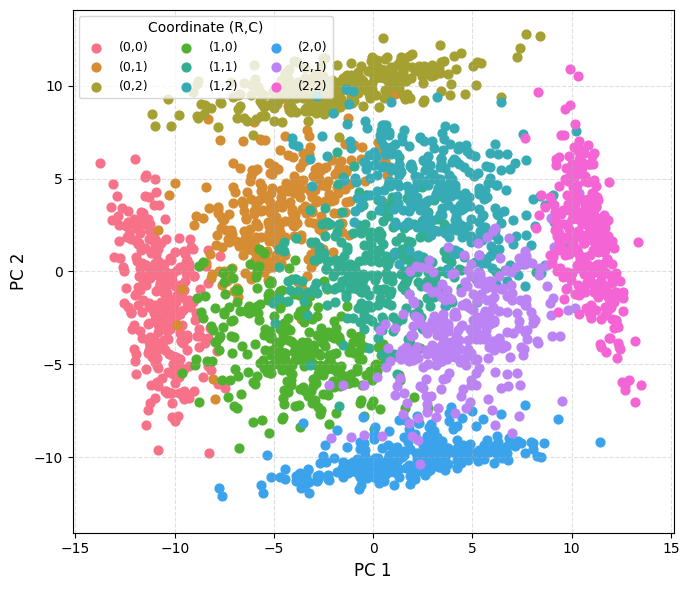


2. Layer 7: Coordinate-based representation
Running PCA analysis for Layer 7...


Layer 7: 100%|██████████| 300/300 [00:05<00:00, 58.98it/s]


Collected 2700 node vectors


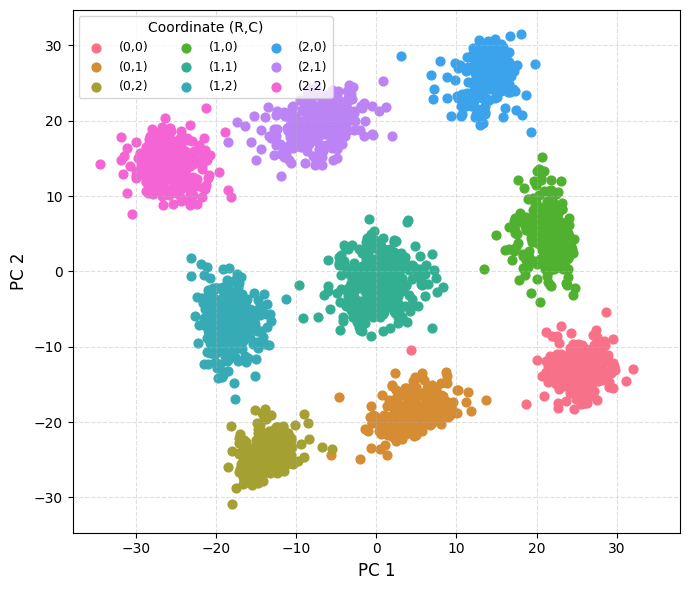


3. Layer 12: Interactive 3D coordinate-based representation
Running PCA analysis for Layer 12...


Layer 12: 100%|██████████| 300/300 [00:12<00:00, 23.56it/s]


Collected 4796 node vectors
Generating interactive 3D scatter plot...


In [ ]:
# Execute PCA analysis for different layers
print("="*60)
print("PCA ANALYSIS: HIDDEN STATE STRUCTURE ACROSS LAYERS")
print("="*60)

# Layer 1: 2D PCA (3x3 grid, coordinate-based)
print("\n1. Layer 1: Coordinate-based representation")
layer1_points = run_pca_analysis(model, tokenizer, layer_idx=1, grid_size=3, num_prompts=300, walk_length=120)
pca1, coords1 = plot_coordinate_colored_pca(layer1_points, layer_idx=1, grid_size=3)

# Layer 7: 2D PCA (3x3 grid, coordinate-based)  
print("\n2. Layer 7: Coordinate-based representation")
layer7_points = run_pca_analysis(model, tokenizer, layer_idx=7, grid_size=3, num_prompts=300, walk_length=120)
pca7, coords7 = plot_coordinate_colored_pca(layer7_points, layer_idx=7, grid_size=3)

# Layer 12: Interactive 3D PCA (4x4 grid, coordinate-based)
print("\n3. Layer 12: Interactive 3D coordinate-based representation")
layer12_points = run_pca_analysis(model, tokenizer, layer_idx=12, grid_size=4, num_prompts=300, walk_length=200)
pca12, coords12 = plot_interactive_3d_pca(layer12_points, layer_idx=12, grid_size=4)

In [4]:
# Linear Probing Analysis

import os
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm
from collections import defaultdict
from utils.grid_utils import *
from utils.model_utils import *

# Configuration
NUM_WALKS = 250
MAX_WALK_LENGTH = 120
MIN_WALK_LENGTH = 120
ACTIVATION_CACHE_PATH = 'activation_cache.pt'

class ActivationCache:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.residual_cache = defaultdict(list)
        self.mlp_cache = defaultdict(list)

    def _get_residual_hook(self, layer_idx):
        def hook_fn(module, input, output):
            self.residual_cache[layer_idx].append(input[0].squeeze(0).detach().cpu())
        return hook_fn

    def _get_mlp_hook(self, layer_idx):
        def hook_fn(module, input, output):
            self.mlp_cache[layer_idx].append(output.squeeze(0).detach().cpu())
        return hook_fn

    def __enter__(self):
        for i, block in enumerate(self.model.transformer.h):
            self.hooks.append(block.register_forward_hook(self._get_residual_hook(i)))
            self.hooks.append(block.mlp.act.register_forward_hook(self._get_mlp_hook(i)))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        for hook in self.hooks:
            hook.remove()

    def clear(self):
        self.residual_cache.clear()
        self.mlp_cache.clear()

def substring_positions(haystack, needle):
    """Find all occurrences of needle in haystack."""
    result = []
    start = 0
    while True:
        idx = haystack.find(needle, start)
        if idx == -1: break
        result.append((idx, idx + len(needle)))
        start = idx + 1
    return result

# Generate activation dataset
if os.path.exists(ACTIVATION_CACHE_PATH):
    os.remove(ACTIVATION_CACHE_PATH)

processed_data = []

with ActivationCache(model) as collector:
    pbar = tqdm(range(NUM_WALKS), desc="Generating walks")
    for _ in pbar:
        collector.clear()
        
        current_nodes = generate_random_names(16)
        G_walk = get_grid_graph(current_nodes, size=4)
        grid_nodes = list(G_walk.nodes()) # returns nodes in grid order
        node_to_coords_walk = {}
        
        # Map each node to its actual position in the grid
        for i, node in enumerate(grid_nodes):
            r = i // 4
            c = i % 4
            node_to_coords_walk[node] = (r, c)
        
        start_node = random.choice(list(G_walk.nodes()))
        length = random.randint(MIN_WALK_LENGTH, MAX_WALK_LENGTH)
        walk = generate_random_walk(G_walk, start_node, length)
        prompt = walk_to_string(walk, G_walk)
        
        if not prompt: continue

        enc = tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        offsets = enc['offset_mapping'].squeeze(0).tolist()
        
        with torch.no_grad():
            model(enc['input_ids'])

        if not collector.residual_cache: continue

        residual_activations_by_layer = torch.stack([collector.residual_cache[i][0] for i in sorted(collector.residual_cache.keys())])
        mlp_activations_by_layer = torch.stack([collector.mlp_cache[i][0] for i in sorted(collector.mlp_cache.keys())])
        
        # Extract activations for each node token
        for node_name, coords in node_to_coords_walk.items():
            spans = substring_positions(prompt, node_name)
            for start_char, end_char in spans:
                target_token_idx = -1
                for i, (start_offset, end_offset) in enumerate(offsets):
                    if end_offset == end_char:
                        target_token_idx = i
                        break
                
                if target_token_idx != -1:
                    processed_data.append({
                        'token': node_name,
                        'x': coords[1],  # column (x-coordinate)
                        'y': coords[0],  # row (y-coordinate)
                        'activations': residual_activations_by_layer[:, target_token_idx, :],
                        'mlp_activations': mlp_activations_by_layer[:, target_token_idx, :]
                    })
        
        pbar.set_postfix({'Data points': len(processed_data)})

torch.save(processed_data, ACTIVATION_CACHE_PATH)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Generating walks: 100%|██████████| 250/250 [00:31<00:00,  7.98it/s, Data points=3e+4] 


Training probes: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]


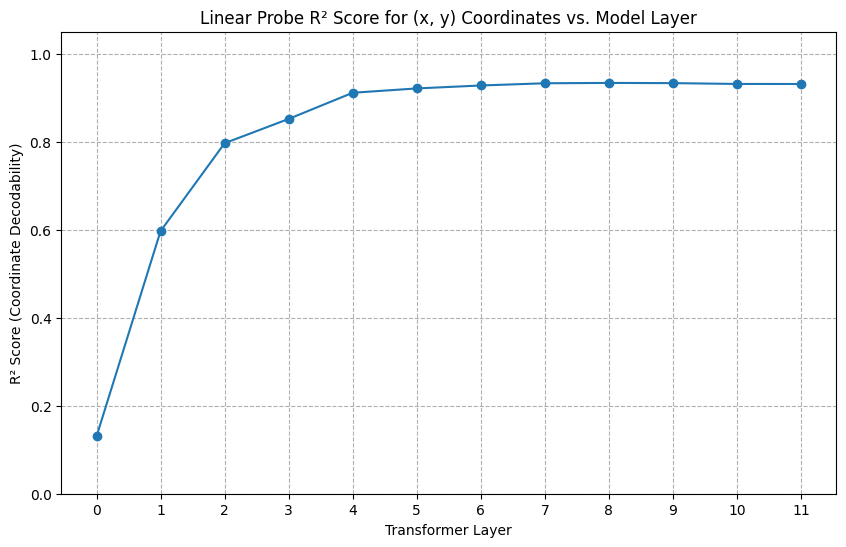

Best coordinate representation: Layer 8 (R² = 0.9336)


In [5]:
# Probe Training and Analysis

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

activation_data = torch.load(ACTIVATION_CACHE_PATH)
num_layers = model.config.n_layer

activations_by_layer = [[] for _ in range(num_layers)]
labels = []

for point in activation_data:
    for layer_idx in range(num_layers):
        activations_by_layer[layer_idx].append(point['activations'][layer_idx])
    labels.append([point['x'], point['y']])

for i in range(num_layers):
    activations_by_layer[i] = torch.stack(activations_by_layer[i]).numpy()
labels = np.array(labels)

probe_scores = []

for layer_idx in tqdm(range(num_layers), desc="Training probes"):
    X = activations_by_layer[layer_idx]
    y = labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    probe = LinearRegression()
    probe.fit(X_train, y_train)
    
    score = probe.score(X_test, y_test)
    probe_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(num_layers), probe_scores, marker='o', linestyle='-')
plt.title('Linear Probe R² Score for (x, y) Coordinates vs. Model Layer')
plt.xlabel('Transformer Layer')
plt.ylabel('R² Score (Coordinate Decodability)')
plt.xticks(range(num_layers))
plt.ylim(0, 1.05)
plt.grid(True, which='both', linestyle='--')
plt.show()

best_layer = np.argmax(probe_scores)
best_score = probe_scores[best_layer]
print(f"Best coordinate representation: Layer {best_layer} (R² = {best_score:.4f})")